In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from cosine_lr_scheduler import CosineLRScheduler
from custom_tokenizer import BytePairEncodingTokenizer
import os, random

# load trained tokenizer
tokenizer = BytePairEncodingTokenizer()
tokenizer.load_tokenizer('tokenizer.pkl')
tokenizer.maxlen = 128

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
reset_random_seeds()

2025-05-16 08:08:30.321060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 08:08:30.334952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 08:08:30.339385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 08:08:30.349864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 08:08:31.018886: W tensorflow/compiler/tf2

In [2]:
import re
from string import punctuation
from tqdm import tqdm

def preprocess_text(x):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x)
    
    
    
    punct_to_keep = """!,.:#?"-;//%$(){}@^*+<=>\\|'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    
    return re.sub(r'\s+', ' ', x).strip()

In [3]:
# load and preprocess data

df = pd.read_csv("/home/bibek/dataset/all_news_summary.csv")

Y = [preprocess_text(x) for x in tqdm(df.headlines)]
X = [preprocess_text(x) for x in tqdm(df.text)]

100%|████████████████████████████████| 168724/168724 [00:09<00:00, 17003.27it/s]


In [4]:
X[0],Y[0]

("central has announced a red haute saturday for its customers in india ' s first ' you shop , we pay ' on july 14 . get everything at 50 % off * on over 200 brands and 50 % cashback * in your central wallet powered by future pay . also , register for the red haute pass , which is fully redeemable at central stores , for priority billing .",
 "central announces ' red haute saturday ' on 14th july")

In [5]:
# shuffle data

data = [(x,y) for x,y in zip(X,Y)]
np.random.shuffle(data)
X = [x[0] for x in data]
Y = [x[1] for x in data]

In [6]:
from sklearn.model_selection import train_test_split

# tokenize and pad sequences

tokenizer.maxlen = 128
X = [tokenizer.tokenize(x) for x in tqdm(X)]

tokenizer.maxlen = 32
Y = [tokenizer.tokenize(x) for x in tqdm(Y)]

tokenizer.maxlen = 128
X = np.array([tokenizer.add_padding(x) for x in X],np.int16)

tokenizer.maxlen = 32
Y = np.array([tokenizer.add_padding(x) for x in Y],np.int16)

100%|████████████████████████████████| 168724/168724 [00:06<00:00, 25204.06it/s]


In [7]:
# split data
# train 70%
# test 20%
# val 10%

xtrain,xval,ytrain,yval = train_test_split(X,Y,train_size=0.7,random_state=0)
xtest,xval,ytest,yval = train_test_split(xval,yval,train_size=0.66,random_state=0)

In [8]:
for _ in range(5): 

    i = np.random.randint(0,len(xtrain)-1)
    
    print(' '.join([tokenizer.i2w[t] for t in xtrain[i] if t > 0]))
    print()
    print(' '.join([tokenizer.i2w[t] for t in ytrain[i] if t > 0]))
    print("---------------------------------------------------------------------")
    

<cls> actress amber heard broke down in court as she testified against her ex - husband , actor johnny d epp during the ongoing def am at ion trial . she can be seen wiping her nose with a tissue and then appears to be posing for the media for a few seconds , claimed social media users . several twitter users shared videos while all eg ing that she posed for photos . nn <sep>

<cls> d epp ' s supporters claim amber heard posed for photo while crying in court , video surfaces <sep>
---------------------------------------------------------------------
<cls> the wife of b sf jaw an te j ba had u r y ada v has said that he is now getting fruits , cheese and salad . ' he is now being served delicious stuff in each meal , ' she added . she also told the delhi high court that she is satisfied with her husband ' s well - being . notably , y ada v had complained about the poor quality of food in a video . <sep>

<cls> b sf jaw an getting fruits , cheese and salad , claims wife <sep>
-----------

In [9]:
xtrain.shape,xtest.shape,xval.shape

((118106, 128), (33407, 128), (17211, 128))

In [10]:
# set training params

MAXLEN = 128
BATCH = 32
EPOCHS = 3

PEAK_LR = 2e-4
END_LR = 1e-7
INIT_LR = 0

WARMUP_RATE = 0.05

# load and robust_net model

i1 = tf.keras.layers.Input((MAXLEN,),BATCH,tf.int16)
i2 = tf.keras.layers.Input((MAXLEN//4 - 1,),BATCH,tf.int16)

model = tf.keras.models.load_model('robust_net.keras')
model([i1,i2])

model.summary()


I0000 00:00:1747363200.029518    8257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747363200.054833    8257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747363200.055038    8257 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747363200.457053    8257 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "robust_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ factorized_embedding_layer      │ ?                      │     1,957,760 │
│ (FactorizedEmbeddingLayer)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block (EncoderBlock)    │ ?                      │     1,054,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block (DecoderBlock)    │ ?                      │     1,316,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 31, 15037)        │     3,864,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,192,829 (31.25 MB)

 Trainable params: 8,192,829 (31.25 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# load pretrained weights

model.load_weights('robust_net.weights.h5')


In [12]:
# set optmizer and loss function
# prepare tensor data for training and validation

opt = tf.keras.optimizers.AdamW(weight_decay=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=BATCH, drop_remainder=True).shuffle(buffer_size=1000)

val = tf.data.Dataset.from_tensor_slices((xval,yval))
val = val.batch(batch_size=BATCH * 2).shuffle(buffer_size=1000)

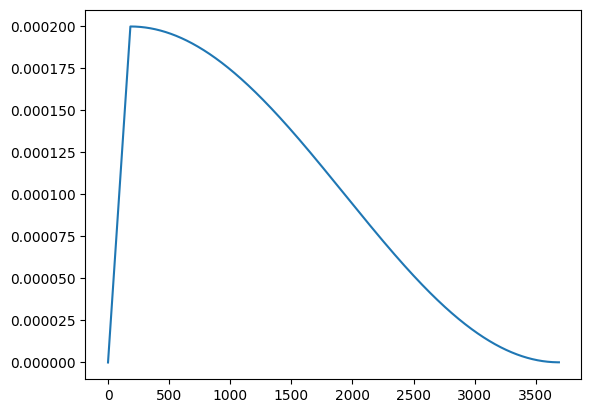

In [13]:
import matplotlib.pyplot as plt
from cosine_lr_scheduler import CosineLRScheduler

# linear lr warmup with cosine decay

steps = xtrain.shape[0] // BATCH

lr_scheduler = CosineLRScheduler(steps,peak_lr=PEAK_LR,min_lr=END_LR,
                                 init_lr=INIT_LR,warmup_rate=WARMUP_RATE)

plt.plot([lr_scheduler(i+1) for i in range(steps)])

In [14]:
@tf.function
def train_step(x,y):
    tar_in = y[:,:-1]
    tar_out = y[:,1:]
    with tf.GradientTape() as tape:
        pred = model([x,tar_in],training=True)
        loss = loss_fn(tar_out,pred,sample_weight=tar_out>0)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss

@tf.function
def test_step(x,y):
    tar_in = y[:,:-1]
    tar_out = y[:,1:]
    pred = model([x,tar_in],training=False)
    loss = loss_fn(tar_out,pred,sample_weight=tar_out>0)
    return loss

In [15]:
# sample output function

def sample(x,y,return_out=False):

    en_in = x[np.newaxis,:]
    dec_in = np.array([[1]],np.int16)
    out = []

    for _ in range(MAXLEN):

        p = model([en_in,dec_in])
        tok = np.argmax(p[0,-1,:],axis=-1)
        out.append(tok)

        if tok == tokenizer.w2i['<sep>'] or len(out) == MAXLEN:
            break

        tok = np.array([tok],np.int16)
        dec_in = np.concatenate([dec_in[0],tok],axis=0)[np.newaxis,:]

    print('input : ',' '.join([tokenizer.i2w[t] for t in x if t>0]).replace('|','\n'))
    print()
    print('actual : ', ' '.join([tokenizer.i2w[t] for t in y if t > 0]))
    print()
    print('predicted :',' '.join([tokenizer.i2w[t] for t in out]))
    print("---------------------------------------------------------------------")
    
    if return_out:
        return out

In [16]:
out = sample(xval[-1],yval[-1],True)

input :  <cls> a uk - based company called s u rr e y nano systems has developed a new version of van tab lack which is the darkest known material and is capable of absorbing 99 . 96 % of incident light . the new version is said to be darker than the previous one . the company was unable to determine the percentage of the absorbed light as its spec t rome ter s couldn ' t measure the same . <sep>

actual :  <cls> uk company develops darkest known material <sep>

predicted : the company has been able to determine the percentage of the total of the total of the total of the total of the total of the total of the total of the total of the total of the total of the total of the total of the total of the total of the total . <sep>
---------------------------------------------------------------------


In [17]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
from nltk import word_tokenize

# bleu and rouge computation functions

def compute_bleu(preds, refs):
    """
    preds: list of predicted strings
    refs: list of reference strings (same length)
    Returns: average BLEU-1/2/3/4 and ROUGE-L
    """
    assert len(preds) == len(refs), "Number of predictions and references must match."

    smooth_fn = SmoothingFunction().method2

    bleu_scores = {1: [], 2: [], 3: [], 4: []}

    for pred, ref in zip(preds, refs):
        pred_tokens = word_tokenize(pred)
        ref_tokens = word_tokenize(ref)

        # BLEU scores
        for n in range(1, 5):
            weights = tuple((1.0 / n if i < n else 0.0) for i in range(4))
            score = sentence_bleu([ref_tokens], pred_tokens, weights=weights, smoothing_function=smooth_fn)
            bleu_scores[n].append(score)

    # Average scores
    avg_bleu = {f"BLEU-{n}": sum(scores)/len(scores) for n, scores in bleu_scores.items()}

    return avg_bleu

def compute_rouge(preds,ref):
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    final_scores = {'rouge1':0, 'rouge2':0, 'rougeL':0}
    
    
    for pred in preds:
        scores = scorer.score(pred, ref)
        
        for k in scores:
            final_scores[k] += np.mean(scores[k])
            
    for k in final_scores:
        final_scores[k] = final_scores[k] / len(preds)
            
    return final_scores
 

epoch : 1/3


100%|█████████████████████████████████████████| 269/269 [00:11<00:00, 24.39it/s]


train loss: 1.1423
val loss: 1.0187
weights saved!

input :  <cls> a uk - based company called s u rr e y nano systems has developed a new version of van tab lack which is the darkest known material and is capable of absorbing 99 . 96 % of incident light . the new version is said to be darker than the previous one . the company was unable to determine the percentage of the absorbed light as its spec t rome ter s couldn ' t measure the same . <sep>

actual :  <cls> uk company develops darkest known material <sep>

predicted : new version of van tab lack which is the darkest source of dust <sep>
---------------------------------------------------------------------
----------------------------------------------------------------------


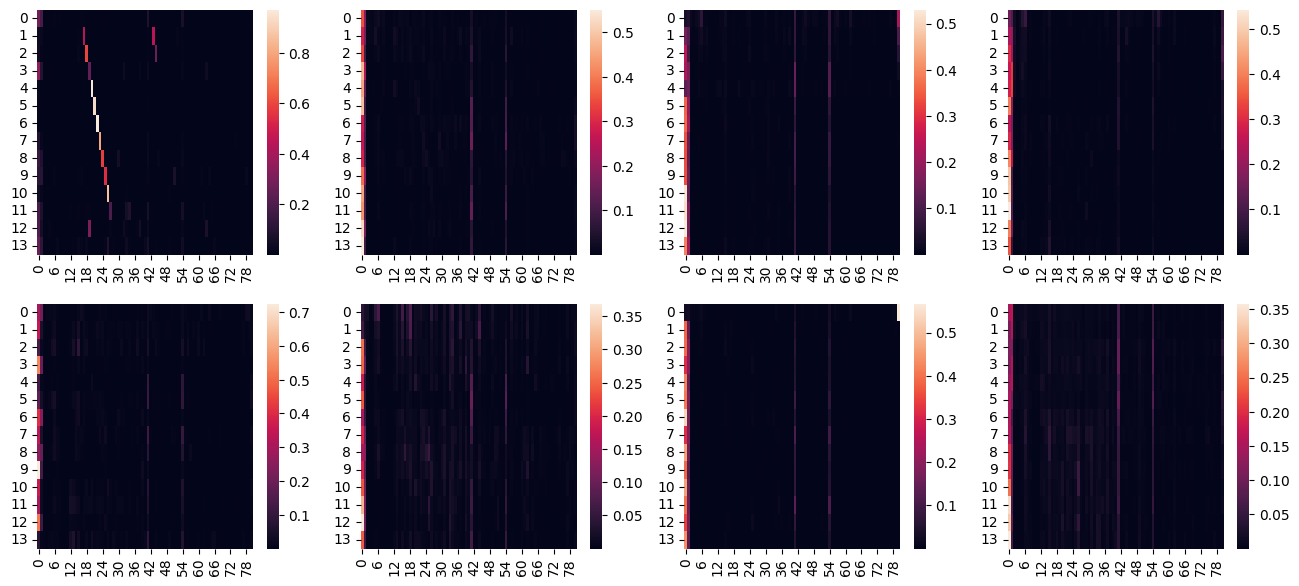

epoch : 2/3


100%|█████████████████████████████████████████| 269/269 [00:10<00:00, 26.24it/s]


train loss: 0.9409
val loss: 0.9508
weights saved!

input :  <cls> a uk - based company called s u rr e y nano systems has developed a new version of van tab lack which is the darkest known material and is capable of absorbing 99 . 96 % of incident light . the new version is said to be darker than the previous one . the company was unable to determine the percentage of the absorbed light as its spec t rome ter s couldn ' t measure the same . <sep>

actual :  <cls> uk company develops darkest known material <sep>

predicted : new version of van tab lack which is the darkest version of 99 . 96 % <sep>
---------------------------------------------------------------------
----------------------------------------------------------------------


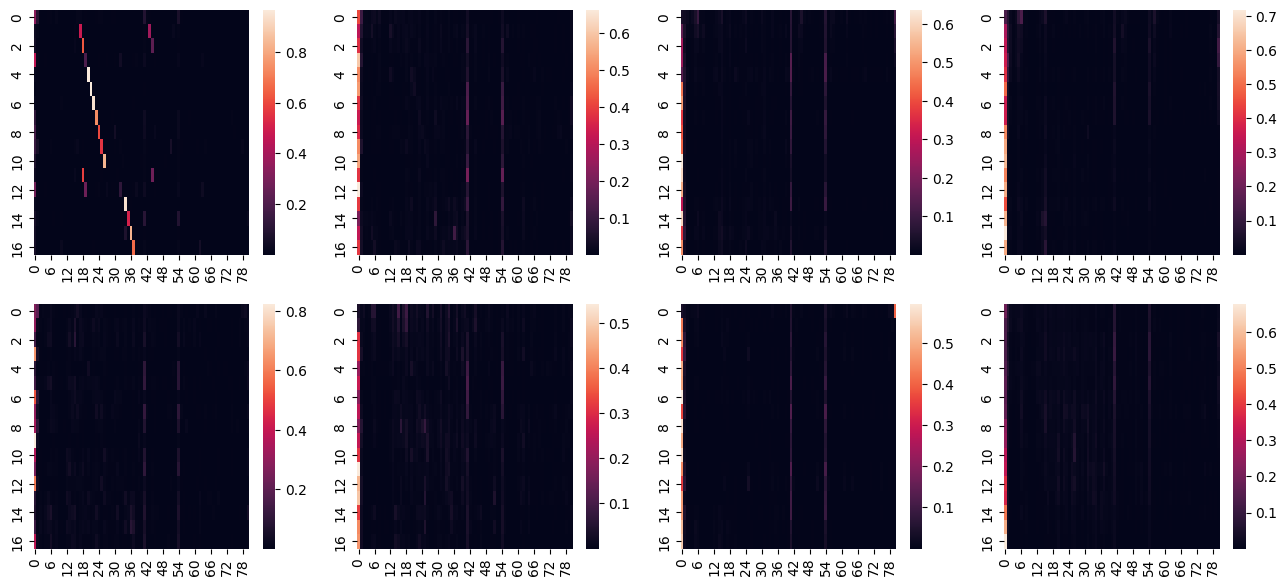

epoch : 3/3


100%|█████████████████████████████████████████| 269/269 [00:09<00:00, 27.44it/s]


train loss: 0.8537
val loss: 0.9214
weights saved!

input :  <cls> a uk - based company called s u rr e y nano systems has developed a new version of van tab lack which is the darkest known material and is capable of absorbing 99 . 96 % of incident light . the new version is said to be darker than the previous one . the company was unable to determine the percentage of the absorbed light as its spec t rome ter s couldn ' t measure the same . <sep>

actual :  <cls> uk company develops darkest known material <sep>

predicted : new version of van tab lack made of 99 . 96 % of light <sep>
---------------------------------------------------------------------
----------------------------------------------------------------------


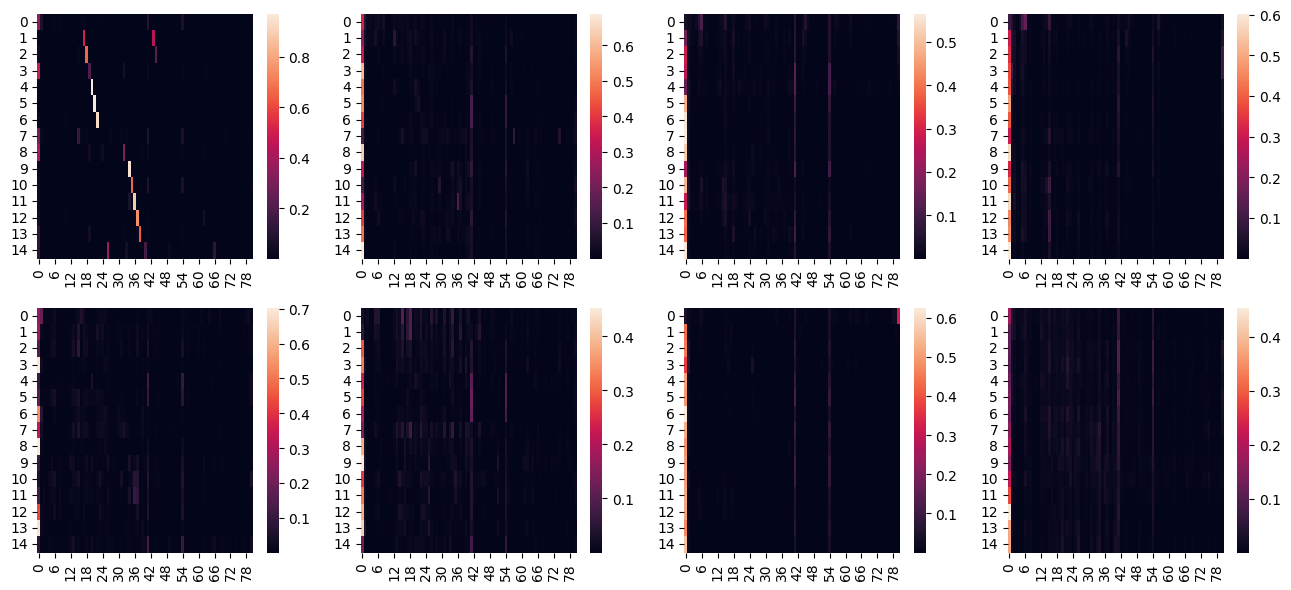

In [18]:
import seaborn as sb

# fine tune model
# show cross attention plot

losses = {'train':[],'valid':[]}

for e in range(EPOCHS):

    e += 1
    print(f'epoch : {e}/{EPOCHS}')

    loss = 0
    
    # run train step 
    for i,(x,y) in enumerate(tqdm(train)):
        # get lr for current step and assign
        lr = lr_scheduler(i+1) 
        opt.learning_rate.assign(lr)
        loss += train_step(x,y)
        
    # save training loss
    train_loss = round(loss.numpy()/(i+ 1),4)
    losses['train'].append(train_loss)
    
    
    loss = 0
    
    # run test step
    for i,(x,y) in enumerate(tqdm(val)):
        loss += test_step(x,y)

    loss = round(loss.numpy() / (i + 1),4)

    print(f'train loss: {train_loss}\nval loss: {loss}')

    if e == 1:
        model.save_weights('vanilla_weights-1.weights.h5')
        print('weights saved!')

    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights('vanilla_weights-1.weights.h5')
        print('weights saved!')

    losses['valid'].append(loss)
    print()
    sample(xval[-1],yval[-1])
    print('----------------------------------------------------------------------')

    attn_scores = model.decoder.decoder_layers[0].mhca.attention_scores
    max_x = attn_scores[0,0,0,:].numpy()
    max_x = np.where(max_x>0)[0][-1]

    attn_scores = attn_scores[:,:,:,:max_x]

    maxlen = attn_scores.shape[2]

    attn_scores = attn_scores.numpy()[0]

    _,ax = plt.subplots(2,4,figsize=(16,7))

    for i in range(2):
        for j in range(4):
            sb.heatmap(np.reshape(attn_scores,(2,4,maxlen,max_x))[i][j],ax=ax[i][j])

    plt.show()           

In [19]:
# load model best weights

model.load_weights("vanilla_weights-1.weights.h5")

In [20]:
from beam_search import BeamSearchDecoder

# intialize beam search

beam_search = BeamSearchDecoder(model,tokenizer,tokenizer)

In [21]:
bleu = {'b1':0,'b2':0,'b3':0,'b4':0}
rouge = {'r1':0,'r2':0,'rL':0}

In [22]:
# get scores from 30 samples

idx = np.arange(30)

for i in range(1,30+1):
    
    x = xtest[-i]
    y = ytest[-i]
    
    actual = ' '.join([tokenizer.i2w[t] for t in y if t > 0])
    
    print("INPUT :",' '.join([tokenizer.i2w[t] for t in x if t > 0]).replace(' | ','\n').replace('<cls>','<cls>\n'))
    print()
    print("ACTUAL :",actual)
    print()
    
    beam1 = beam_search.summarize(x,ymax=MAXLEN,k=1,alpha=0.7)[0][0]
    beam3 = beam_search.summarize(x,ymax=MAXLEN,k=3,alpha=0.7)[0][0]
    
    print("1 BEAM :",beam1)
    print("3 BEAM :",beam3)
    
    scores = compute_bleu([beam1,beam3],[actual,actual])
    
    for a,b in zip(bleu,scores):
        bleu[a] += scores[b]
    
    print()
    print(scores)
    
        
    scores = compute_rouge([beam1,beam3],actual)
    
    for a,b in zip(rouge,scores):
        rouge[a] += scores[b]
    
    print(scores)
    print("--------------------------------------------------------------------------------------")


INPUT : <cls>
 a 22 - year - old woman from be ng al u r u has accused an o la driver of watching porn and holding his phone in such a manner that she could see it during a ride . the woman , in her complaint to police , said that the driver ma st u rb ate d as well and refused to stop the ride despite being asked repeatedly . the driver is currently abs con ding . <sep>

ACTUAL : <cls> o la driver shows porn to woman , ma st u rb ate s during ride <sep>

1 BEAM : <cls> woman accused of watching porn in a way to see it <sep>
3 BEAM : <cls> woman accuses o la driver of watching porn in ride <sep>

{'BLEU-1': 0.45498934287371234, 'BLEU-2': 0.3574643446270164, 'BLEU-3': 0.28655178799208963, 'BLEU-4': 0.20388157218480318}
{'rouge1': 0.4501742341498933, 'rouge2': 0.11374158249158249, 'rougeL': 0.38125162531856244}
--------------------------------------------------------------------------------------
INPUT : <cls>
 ground w al a , an online sports venue and facility booking service , is orga

1 BEAM : <cls> all new plant at ion s to be organic , organic plant <sep>
3 BEAM : <cls> all new plant at ion s to be organic and organic : raja st han <sep>

{'BLEU-1': 0.44047619047619047, 'BLEU-2': 0.336923648609191, 'BLEU-3': 0.26460324766995236, 'BLEU-4': 0.18070971888989068}
{'rouge1': 0.3355351170568562, 'rouge2': 0.0, 'rougeL': 0.3355351170568562}
--------------------------------------------------------------------------------------
INPUT : <cls>
 denying accusations of copying his ' ba ads ha ho ' song ' pi ya more ' from the 2014 song ' n ash a s ar pe chad k e bo le ' , music director an kit t i war i said , " i ' m a musician , not a thief . " he added , " every music composer has his . own distinct style . two of my songs , bo on d bo on d and q at ra q at ra are similar too . " t i war i further said " copying " and being " similar ' " are two different things . <sep>

ACTUAL : <cls> i ' m musician , not thief : an kit t i war i over p lag ia rising song <sep>

1 BEAM : <

1 BEAM : <cls> ha ryan a cm seeks ' coordinated efforts ' for f o et ic ide <sep>
3 BEAM : <cls> ha ryan a cm seeks ' coordinated efforts ' to check f o et ic ide <sep>

{'BLEU-1': 0.4880952380952381, 'BLEU-2': 0.4261595713555904, 'BLEU-3': 0.37604230542343187, 'BLEU-4': 0.3232155516550813}
{'rouge1': 0.4410885331143952, 'rouge2': 0.21872201872201874, 'rougeL': 0.4410885331143952}
--------------------------------------------------------------------------------------
INPUT : <cls>
 a woman was arrested for hugging singer ma ji d al - mo hand is at a concert in saudi arabia . a video shows her running towards the stage and hugging ma ji d while security personnel attempt to pull her off him . she was later escort ed out of the concert venue by security personnel . a public prosecutor is considering harassment charges against the woman , police said . <sep>

ACTUAL : <cls> woman arrested for hugging male singer at saudi concert <sep>

1 BEAM : <cls> woman held for hugging singer ma ji d a

1 BEAM : <cls> j p n add a launches breastfeeding campaign <sep>
3 BEAM : <cls> ' m aa - mother ' s breastfeeding campaign launched <sep>

{'BLEU-1': 0.5669642857142857, 'BLEU-2': 0.5126008725976521, 'BLEU-3': 0.43324998273196463, 'BLEU-4': 0.3426930378323209}
{'rouge1': 0.6689814814814814, 'rouge2': 0.3150844525844526, 'rougeL': 0.6037037037037036}
--------------------------------------------------------------------------------------
INPUT : <cls>
 around 25 kan war i ya s were injured on saturday after the bus they were travelling in over turned and fell into a road side ditch in bi ha r . the incident took place after the bus driver lost control over the vehicle . all the injured were taken to a nearby hospital and are out of danger , police said . <sep>

ACTUAL : <cls> 25 kan war i ya s injured in road accident in bi ha r <sep>

1 BEAM : <cls> kan war i ya s injured after bus falls into road <sep>
3 BEAM : <cls> 25 kan war i ya s injured after bus falls into road <sep>

{'BLEU-1': 

In [25]:
# mean bleu scores

{k:v/len(idx) for k,v in bleu.items()}

{'b1': 0.6067273901992102,
 'b2': 0.5158859822804567,
 'b3': 0.43409655617288134,
 'b4': 0.34709708049060317}

In [26]:
# mean rouge scores

{k:v/len(idx) for k,v in rouge.items()}

{'r1': 0.5723009093852228, 'r2': 0.2957549792561579, 'rL': 0.5171855402170094}